# TODO
- Feature Pyramid
https://github.com/yhenon/pytorch-retinanet

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import sklearn
from sklearn import metrics
import pydicom
from matplotlib.patches import Rectangle
from collections import namedtuple, defaultdict

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('/home/paperspace/data/pneumonia')

In [4]:
BBox = namedtuple('BBox', 'x1 y1 x2 y2')

In [27]:
boxes_file = PATH/'train_reversed_128.csv'
file2boxes = pd.read_csv(boxes_file)
file2boxes.set_index('patientId', inplace=True)
file2targets = pd.read_csv(PATH/'train_targets_128.csv')
file2targets.set_index('patientId', inplace=True)
train_n = file2boxes.shape[0]
train_n

25684

In [28]:
bbox_map = defaultdict(list)
for file_name ,row in file2boxes.iterrows():
    if not pd.isna(row['bboxes']):
        spl = row['bboxes'].split()
        for i in range(0,len(spl),4):
            box = BBox(int(spl[i]),int(spl[i+1]),int(spl[i+2]),int(spl[i+3]))
            bbox_map[file_name].append(box)

In [29]:
def show_prediction(img_data, pred, truth, ax):
    show_img(img_data,ax=ax)
    draw_rects(ax, truth)
    draw_rects(ax, pred, 'blue')

def area(b):
    if b.x1 >= b.x2 or b.y1 >= b.y2: return 0
    return (b.x2-b.x1)*(b.y2 - b.y1)
area(BBox(0,0,100,100))

def ar2boxes(b):
    res =[]
    for i in range(0,len(b),4):
        bint = [int(round(x)) for x in b[i:i+4]]
        box = BBox(*bint)
        if area(box) >1: res.append(box)
    return res


def IoU(b1, b2):
    ab1 = area(b1)
    ab2 = area(b2)
    if ab1 <1 or ab2 < 1: return 0
    inter = BBox(max(b1.x1,b2.x1), max(b1.y1,b2.y1), min(b1.x2,b2.x2), min(b1.y2,b2.y2))
    union = ab1+ab2-area(inter)
    return area(inter)/union

def score_tre(tresh, preds, actuals):
    pred_hits = np.full(len(preds), False)
    act_hits = np.full(len(actuals), False)
    for pi in range(len(preds)):
        for ai in range(len(actuals)):
            if pred_hits[pi] or act_hits[ai]: continue
            b1,b2 = preds[pi], actuals[ai]
            if IoU(b1,b2) >= tresh: pred_hits[pi]=act_hits[ai]=True
    tp = np.sum(pred_hits == True)
    fp = np.sum(pred_hits == False)
    fn = np.sum(act_hits == False)
    #print(tp,fp,fn)
    return tp / (tp+fp+fn)
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score_tre(.1, p,a)

def score(preds, actuals):
    ret =0
    for thr in np.linspace(0.4,0.75,8):
        ret+= score_tre(thr, preds,actuals)
    return ret/8
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score(p,a)    

def score_all(pred, truth):
    assert len(pred) == len(truth)
    sum = 0
    cnt = 0
    for idx in range(len(pred)):
        pred_box = ar2boxes(pred[idx])
        true_box = ar2boxes(truth[idx])
        if pred_box or true_box:
            sum += score(pred_box, true_box)
            cnt += 1
    return sum / cnt


In [30]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def bb_hw(bb): return np.array([bb[1], bb[0], bb[3]-bb[1], bb[2]-bb[0]])

def draw_box(ax,box, color='red'):
    draw_rect(ax, list(box), color)
def draw_boxes(ax, boxes, color='red'):
    for box in boxes: draw_box(ax,box,color)

def draw_rect(ax, b, color='red'):
    patch = ax.add_patch(Rectangle(b[:2],*b[-2:], fill=False, edgecolor=color))

def draw_rects(ax, boxes, color='red'):
    for i in range(0,len(boxes),4):
        draw_rect(ax,bb_hw(boxes[i:i+4]),color)

def display(file_name,ax=None):
    if ax is None:
        _,ax = plt.subplots(1,1)
    ax.imshow(PIL.Image.open(PATH/file_name))
    boxes =bbox_map[str(Path(file_name).name)]
    for box in boxes:
        x1,y1,w,h = bb_hw(box)
        ax.add_patch(Rectangle(xy=(x1,y1),width=w,height=h,alpha = 0.5, fill=False, color='red'))
    return ax

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [31]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(5136,)

In [32]:
bs  = 128
arch = resnet34
sz=128

In [33]:
def get_data(sz):
    augs = [RandomFlip(tfm_y=TfmType.COORD),
            RandomRotate(5, p=0.5,tfm_y=TfmType.COORD),
            RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
    tfms = tfms_from_model(arch, sz, tfm_y=TfmType.COORD, aug_tfms=augs)
    data = ImageClassifierData.from_csv(PATH, 'train_png128', boxes_file,
                                    val_idxs=val_idxs,test_name='test_png128', tfms=tfms,bs=bs,continuous=True)
    return data

In [34]:
data = get_data(sz)
md = data

In [35]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [36]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [37]:
anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [38]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        #self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        #x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]


In [39]:
alpha,gamma = 0.25,2
def get_weights(xs, ts):
    x = ts * xs + (1-ts)*(1-xs)
    return alpha * (1-x).pow(gamma)

def focal_loss(x, t):
    w = get_weights(x.sigmoid(), t)
    return F.binary_cross_entropy_with_logits(x,t,w) * len(x)

In [40]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [41]:
def get_y(bbox):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()
    bb_keep = bb_keep[:,0]
    return bbox[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx


def ssd_1_loss(activ,conf, tar_box):
    a_ic = actn_to_bb(activ, anchors)
    if len(tar_box.nonzero())==0:
        actual = V(torch.zeros(len(conf)).float())
        return 0, focal_loss(conf.view(-1), actual)
    bbox = get_y(tar_box)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    conf_loss =focal_loss(conf.view(-1), V(pos.float()))
    if len(pos_idx) > 0: 
        conf_loss /= len(pos_idx)
    return loc_loss*10, conf_loss

def ssd_loss(pred,targ,print_it=False):
    lng,lls = 0.,0.
    for conf,activ, tar_box in zip(*pred,targ):
        loc_loss,neg_loss = ssd_1_loss(activ,conf, tar_box)
        lls += loc_loss
        lng += neg_loss
    if print_it: print(f'loc: {lls.data[0]}, neg: {lng.data[0]}')
    return lls+lng

# Create and train model

In [48]:
'''def class_data(sz):
    tfms = tfms_from_model(arch, sz)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_targets.csv', val_idxs=val_idxs, tfms=tfms)
    return data
class_learn = ConvLearner.pretrained(arch, class_data(sz))
class_learn.load('toyclass')

def my_model(pretrained):
    return class_learn.model'''

In [42]:
pi = 0.01
b = -np.log((1-pi)/pi)
head_reg4 = SSD_MultiHead(k, b)
#models = ConvnetBuilder(my_model, 0, 0, 0, xtra_cut = 10,custom_head=head_reg4)
models = ConvnetBuilder(resnet34, 0, 0, 0,custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit=ssd_loss

 72%|███████▏  | 116/161 [01:03<00:24,  1.82it/s, loss=161] 

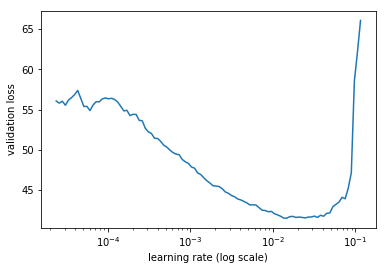

In [43]:
learn.lr_find()
learn.sched.plot()

In [44]:
learn.fit(5e-3, 3)

epoch      trn_loss   val_loss                              
    0      33.225007  28.912088 
    1      28.228991  26.374051                             
    2      26.795728  25.275267                             


[array([25.27527])]

In [45]:
learn.unfreeze()

In [46]:
lr = 1e-3
lrs = [lr/9,lr/3,lr]

In [47]:
learn.fit(lrs, 3, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      23.888508  22.394405 
    1      22.343778  22.012013                             
    2      21.150997  20.221464                             
    3      20.674294  20.145363                             
    4      20.190194  19.657441                             
    5      19.784896  19.822886                             
    6      19.01263   20.015885                             


[array([20.01589])]

In [87]:
lr = 1e-4
lrs = [lr/9,lr/3,lr]

In [88]:
learn.fit(lrs, 4, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      16.212101  21.040868 
    1      15.720963  21.646654                           
    2      15.259167  21.604555                           
    3      15.036236  21.732806                           
    4      14.76593   21.897828                           
    5      14.412577  21.918511                           
    6      14.325451  22.230043                           
    7      14.080655  22.529629                           
    8      13.798793  22.79187                            
    9      13.589126  22.581906                           
    10     13.457153  22.902767                           
    11     13.328644  22.615059                           
    12     13.232094  23.569033                           
    13     12.973683  22.837553                           
    14     12.898253  23.298145                           


[array([23.29815])]

In [48]:
learn.save('sz128')

In [110]:
learn.load('sz128_sc12')

# Score 

In [49]:
nms_tresh = 0.05
keep_tresh = 0.2

nmss = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
keeps = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for n in nmss:
    for k in keeps:
        nms_tresh, keep_tresh = n,k
        preds = get_pred_boxes(learn.model, data.val_dl)
        sc = score_all(preds, data.val_ds.y)
        print(n,k,sc)

In [50]:
def pick_boxes(prob, boxes):
    to_keep = np.nonzero(prob>keep_tresh)
    return (prob[to_keep], boxes[to_keep])


def nms(prob, boxes):
    removed = np.zeros(len(prob))
    idxs = np.flip(np.argsort(prob,0))
    for i,idx in enumerate(idxs):
        if removed[idx]: continue
        for j in range(i+1, len(idxs)):
            idx2 = idxs[j]
            if not removed[idx2] and IoU(BBox(*boxes[idx]), BBox(*boxes[idx2])) > nms_tresh:
                removed[idx2] = 1
    to_keep = (removed == 0)
    return (prob[to_keep], boxes[to_keep])
        

In [51]:
def get_pred_boxes(model, dl):
    model.eval()
    res = []
    for batch,*_  in iter(dl):
        batch_prob, batch_box = model(V(batch))
        batch_prob = F.sigmoid(batch_prob)
        batch_prob = batch_prob.cpu().data.numpy()
        for prob, box in zip(batch_prob, batch_box):
            box = actn_to_bb(box, anchors).cpu().data.numpy() * 128
            prob = prob.reshape(-1)
            prob,box = pick_boxes(prob.reshape(-1),box )
            prob, picked = nms(prob,box)
            res.append(picked.reshape(-1))
    return res
#data.val_dl.batch_sampler.batch_size=128
preds = get_pred_boxes(learn.model, data.val_dl)

In [52]:
score_all(preds, data.val_ds.y)

0.13629127358490573

# Test Submission

In [53]:
#fastai bug workaround
test_n =data.test_ds.get_n()
z= np.zeros(4*test_n).reshape(-1,4)
data.test_ds.y =z

In [54]:
tp = get_pred_boxes(learn.model, data.test_dl)

In [55]:
def scale(x):
    return int(np.rint(x*8))

In [56]:
def boxes_for_subm(boxes):
    res =[] 
    for i in range(0,len(boxes), 4):
        y1,x1,y2,x2 = boxes[i:i+4]
        rr = [0.1,x1,y1, x2-x1, y2-y1]
        res += [scale(x) for x in rr]
    return res

[1, 182, 478, 227, 214, 1, 549, 506, 241, 252]


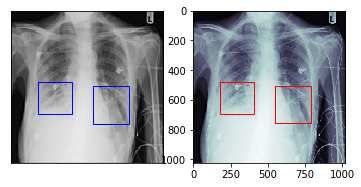

In [57]:
idx = 28
x,_ = next(iter(data.test_dl))
denx = data.test_ds.denorm(to_np(x))
ima=denx[idx]
converted = boxes_for_subm(tp[idx])
print(converted)
_,ax = plt.subplots(1,2)
show_prediction(ima,tp[idx], [], ax[0])
fname = data.test_ds.fnames[idx]
fname=(PATH/fname).stem
c_path='/home/paperspace/data/pneumonia/test/'+fname+'.dcm'
c_dicom = pydicom.read_file(c_path)
ax[1].imshow(c_dicom.pixel_array, cmap='bone')
ax[1].add_patch(Rectangle((converted[1],converted[2]),converted[3],converted[4], fill=False, edgecolor='red'))
ax[1].add_patch(Rectangle((converted[6],converted[7]),converted[8],converted[9], fill=False, edgecolor='red'))


In [58]:
def pred_to_string(x):
    r = boxes_for_subm(x)
    return " ".join([str(y) for y in r])

In [59]:
ids =[Path(f).stem for f in data.test_ds.fnames]
boxes = [pred_to_string(x) for x in tp]
sub_data = list(zip(ids,boxes))
subm_df = pd.DataFrame(sub_data,columns=['patientId','PredictionString'])
subm_df.set_index('patientId', inplace=True)
subm_df.to_csv(PATH/'focal2.csv')


# Debug

In [60]:
x,y = next(iter(data.val_dl))
act = learn.model(V(x))

[0.01164 0.00958 0.00901 0.01458 0.01208 0.01134 0.01751 0.01594 0.01401 0.02866 0.01572 0.01522 0.03978
 0.03225 0.02239 0.04593 0.0497  0.02328 0.01355 0.00831 0.00799 0.0173  0.01468 0.01441 0.02252 0.02078
 0.01827 0.01206 0.00757 0.00893 0.01535 0.01211 0.01479 0.02157 0.01593 0.01914 0.03166 0.02471 0.02039
 0.04753 0.0297  0.0362  0.05607 0.03535 0.05006 0.17253 0.0815  0.06953 0.28457 0.17629 0.13488 0.28222
 0.26787 0.15357 0.03407 0.0186  0.01443 0.06139 0.03097 0.03288 0.09799 0.05417 0.05488 0.01446 0.00898
 0.01008 0.02719 0.01482 0.02055 0.05309 0.0248  0.03453 0.02372 0.01705 0.01734 0.03354 0.02425 0.02755
 0.04343 0.03016 0.03823 0.1159  0.05505 0.0528  0.18423 0.11839 0.08452 0.20847 0.19759 0.11145 0.05501
 0.0246  0.0196  0.09281 0.04339 0.05601 0.17028 0.07429 0.10673 0.0313  0.01626 0.01738 0.05937 0.02764
 0.04273 0.1067  0.0443  0.08538 0.0152  0.01211 0.0137  0.01724 0.0148  0.01613 0.02052 0.01753 0.01851
 0.02963 0.01771 0.02024 0.03906 0.0286  0.02685 0.0463

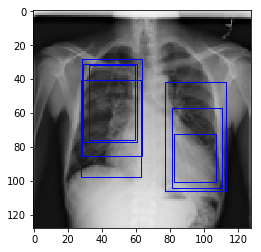

In [61]:
idx=1
activ0p =act[0][idx]
activ0b = act[1][idx]
tar_box0 = V(y)[idx]
activ0p = F.sigmoid(activ0p)
prob = activ0p.cpu().data.numpy().reshape(-1)


act_boxes =actn_to_bb(activ0b, anchors)*128
act_boxes = act_boxes.cpu().data.numpy()
print(prob)
#print(act_boxes)
act_boxes = act_boxes[np.nonzero(prob>0.2)]
#print(act_boxes)
filename = data.val_ds.fnames[idx]
ax =display(filename)
#draw_boxes(ax, anch_boxes, color='white')
draw_rects(ax,act_boxes.reshape(-1), 'blue')

In [62]:
ssd_1_loss(activ0b, activ0p, tar_box0)

(0, Variable containing:
  8.9648
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


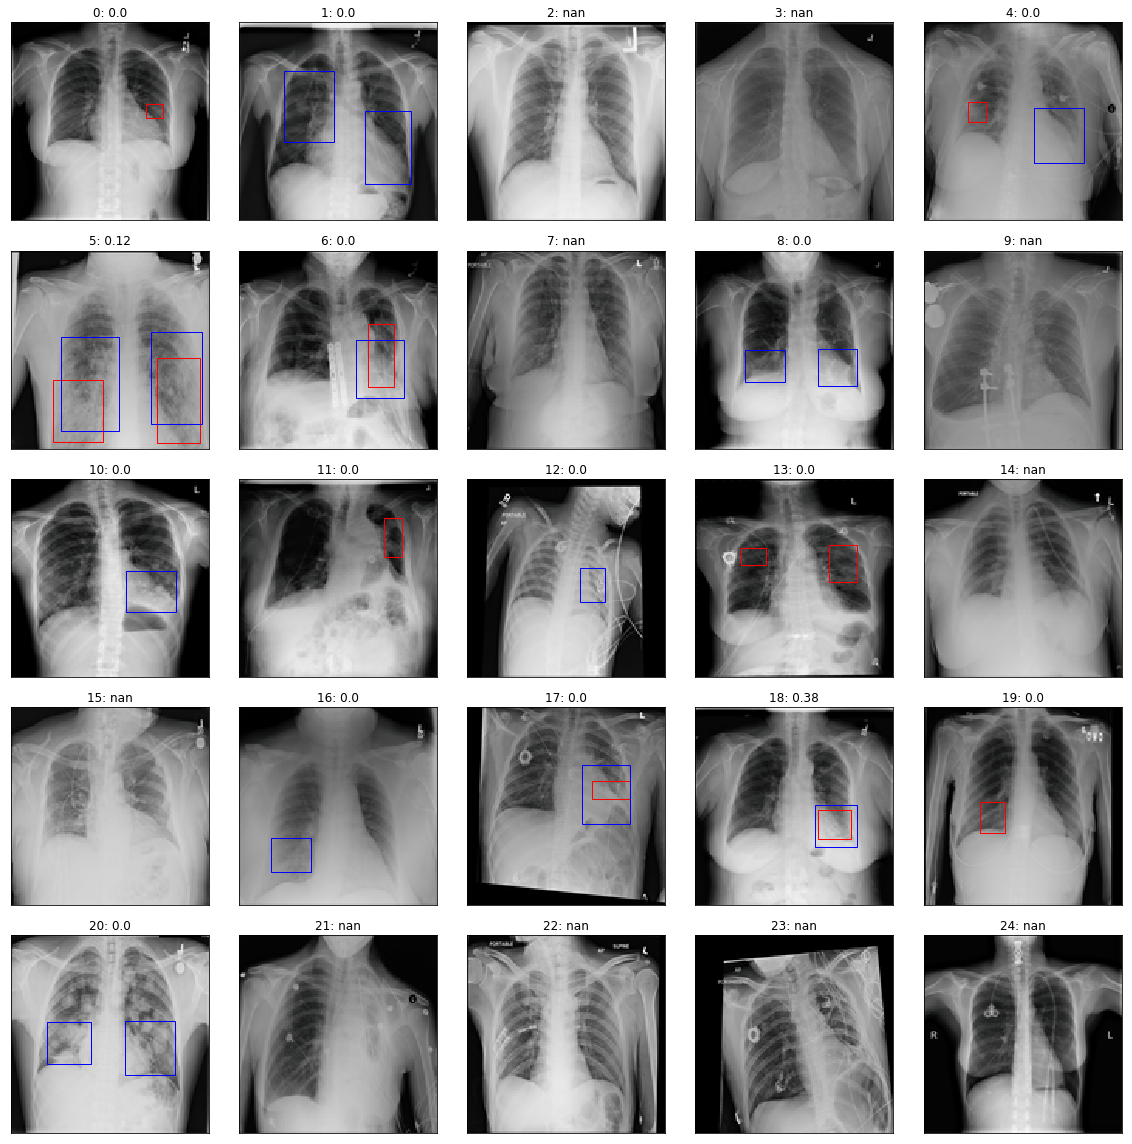

In [63]:
val_it = iter(data.val_dl)
x,y=next(val_it)
_,axs = plt.subplots(5,5,figsize=(16,16))
axs = axs.flatten()
idx=0
denx = data.val_ds.denorm(to_np(x))
y = to_np(y)
for ax in axs:
    #while idx< bs and np.all(y[idx]==0) :idx +=1
    if idx>= bs:
        break
    ima=denx[idx]
    sc = score(ar2boxes(preds[idx]), ar2boxes(y[idx]))
    ax.set_title(f'{idx}: {sc:.2}')
    show_prediction(ima,preds[idx], y[idx], ax)
    idx+=1
plt.tight_layout()

# See augmentations

[29. 70. 71. 96. 20. 27. 87. 48.  0.  0.  0.  0.  0.  0.  0.  0.]
[29. 70. 71. 96. 20. 27. 87. 49.  0.  0.  0.  0.  0.  0.  0.  0.]
[27. 67. 71. 96. 21. 24. 90. 50.  0.  0.  0.  0.  0.  0.  0.  0.]
[29. 70. 71. 96. 20. 27. 87. 48.  0.  0.  0.  0.  0.  0.  0.  0.]
[27. 68. 71. 96. 21. 24. 89. 49.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  30.  72.  58.  18.  78.  86. 102.   0.   0.   0.   0.   0.   0.   0.   0.]


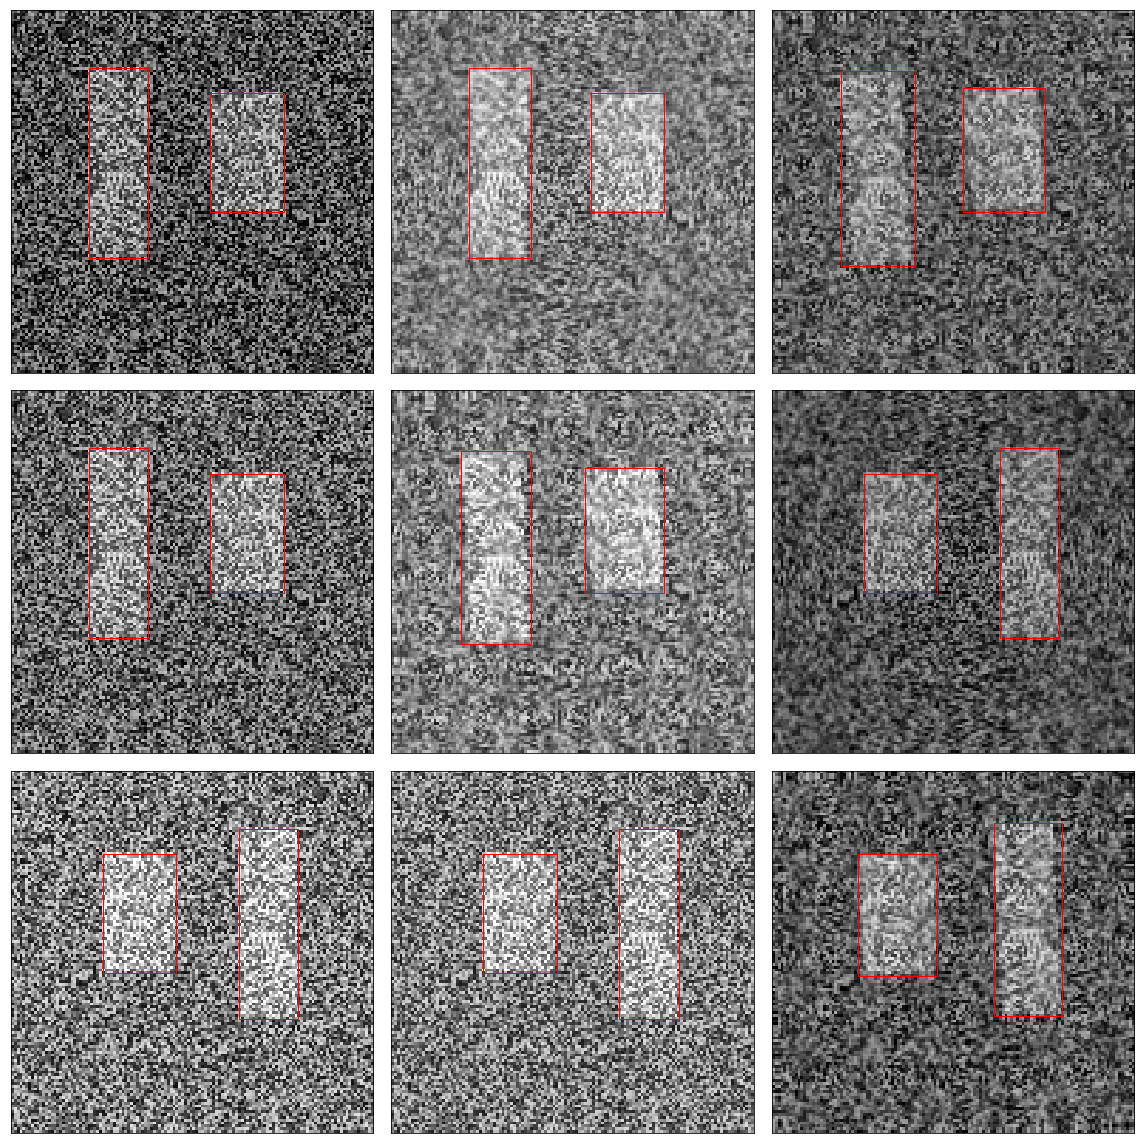

In [35]:
idx=14
fig,axes = plt.subplots(3,3, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(data.aug_dl))
    ima=data.val_ds.denorm(to_np(x))[idx]
    b = to_np(y[idx])
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, bb_hw(b[0:4]))
    draw_rect(ax, bb_hw(b[4:8]))
    draw_rect(ax, bb_hw(b[8:12]))
plt.tight_layout()